Per-Protocol Outcome Model Summary (Logistic Regression):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  667
Model:                            GLM   Df Residuals:                   651.55
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43.138
Date:                Sun, 09 Mar 2025   Deviance:                       86.276
Time:                        17:32:09   Pearson chi2:                     466.
No. Iterations:                    10   Pseudo R-squ. (CS):            0.01439
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

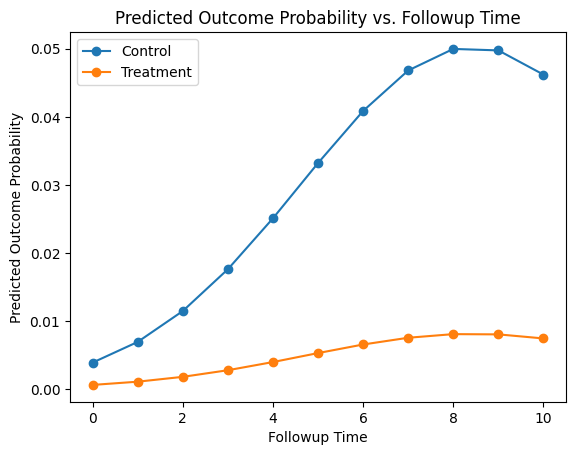

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('dataset/data_censored.csv')

def process_estimand(data, estimand_type):
    if estimand_type == 'PP':
        # Treatment (switch) model only for PP
        eligible_data = data[data['eligible'] == 1].copy()
        
        # Fit numerator and denominator models for treatment
        numerator_model = smf.glm('treatment ~ age', eligible_data, 
                                  family=sm.families.Binomial()).fit()
        denominator_model = smf.glm('treatment ~ age + x1 + x3', eligible_data, 
                                    family=sm.families.Binomial()).fit()
        
        # Predict treatment probabilities
        eligible_data['num_prob_tx'] = numerator_model.predict(eligible_data)
        eligible_data['denom_prob_tx'] = denominator_model.predict(eligible_data)
        
        # Compute stabilized treatment weights
        eligible_data['tx_num'] = np.where(eligible_data['treatment'] == 1,
                                           eligible_data['num_prob_tx'],
                                           1 - eligible_data['num_prob_tx'])
        eligible_data['tx_denom'] = np.where(eligible_data['treatment'] == 1,
                                             eligible_data['denom_prob_tx'],
                                             1 - eligible_data['denom_prob_tx'])
        eligible_data['sw_weight'] = eligible_data['tx_num'] / eligible_data['tx_denom']
        
        # Merge back to original data and set missing weights to 1
        sw_weights = eligible_data[['id', 'period', 'sw_weight']]
        data_processed = pd.merge(data, sw_weights, on=['id', 'period'], how='left')
        data_processed.loc[:, 'sw_weight'] = data_processed['sw_weight'].fillna(1)
    else:
        data_processed = data.copy()
        data_processed['sw_weight'] = 1  # No treatment weighting for ITT
    
    # Censoring models: fit numerator and denominator models for censoring
    numerator_formula = 'censored ~ x2'
    denominator_formula = 'censored ~ x2 + x1'
    censor_num_model = smf.glm(numerator_formula, data_processed,
                               family=sm.families.Binomial()).fit()
    censor_denom_model = smf.glm(denominator_formula, data_processed,
                                 family=sm.families.Binomial()).fit()
    
    # Predict censoring probabilities
    data_processed['num_prob_censor'] = censor_num_model.predict(data_processed)
    data_processed['denom_prob_censor'] = censor_denom_model.predict(data_processed)
    
    # Compute censoring weights
    data_processed['cw_num'] = np.where(data_processed['censored'] == 1,
                                        data_processed['num_prob_censor'],
                                        1 - data_processed['num_prob_censor'])
    data_processed['cw_denom'] = np.where(data_processed['censored'] == 1,
                                          data_processed['denom_prob_censor'],
                                          1 - data_processed['denom_prob_censor'])
    data_processed['cw_weight'] = data_processed['cw_num'] / data_processed['cw_denom']
    
    # Compute cumulative weights over periods
    data_sorted = data_processed.sort_values(['id', 'period'])
    data_sorted['cum_sw'] = data_sorted.groupby('id')['sw_weight'].cumprod()
    data_sorted['cum_cw'] = data_sorted.groupby('id')['cw_weight'].cumprod()
    data_sorted['cum_weight'] = data_sorted['cum_sw'] * data_sorted['cum_cw']
    
    # Drop periods after censoring (using a copy to avoid chained assignment warnings)
    data_sorted['censored_ever'] = data_sorted.groupby('id')['censored'].cummax()
    data_filtered = data_sorted[data_sorted['censored_ever'] == 0].copy()
    
    # Winsorize weights at the 99th percentile
    q99 = data_filtered['cum_weight'].quantile(0.99)
    data_filtered.loc[:, 'cum_weight_win'] = np.minimum(data_filtered['cum_weight'], q99)
    
    # === Mimic trial expansion ===
    # Create extra columns as in the R expanded dataset:
    #   trial_period: the period index,
    #   followup_time: time since trial start (here, assumed equal to period),
    #   assigned_treatment: for simplicity, set equal to treatment.
    data_filtered.loc[:, 'trial_period'] = data_filtered['period']
    data_filtered.loc[:, 'followup_time'] = data_filtered['period']
    data_filtered.loc[:, 'assigned_treatment'] = data_filtered['treatment']
    
    return data_filtered

# Process the data for PP and ITT estimands
pp_data = process_estimand(data, 'PP')
itt_data = process_estimand(data, 'ITT')

def fit_logistic_outcome_model(data, formula):
    """
    Fit a logistic regression outcome model using statsmodels GLM with a binomial family.
    The inverse probability weights (winsorized) are passed as frequency weights.
    """
    model = smf.glm(formula, data=data, family=sm.families.Binomial(),
                    freq_weights=data['cum_weight_win']).fit()
    return model

# Define outcome formulas to mimic the R outcome model:
# For ITT the R formula is:
#   outcome ~ assigned_treatment + x2 + followup_time + I(followup_time^2) + trial_period + I(trial_period^2)
# For PP, we assume a similar model but without x2 adjustment.
formula_itt = "outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)"
formula_pp = "outcome ~ assigned_treatment + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)"

# Fit the logistic outcome models
logit_pp = fit_logistic_outcome_model(pp_data, formula_pp)
logit_itt = fit_logistic_outcome_model(itt_data, formula_itt)

print("Per-Protocol Outcome Model Summary (Logistic Regression):")
print(logit_pp.summary())
print("\nIntention-to-Treat Outcome Model Summary (Logistic Regression):")
print(logit_itt.summary())

# === Graph: Predicted Outcome Probability vs. Followup Time ===
# To generate a graph comparable to the R analysis, we create a new dataset that spans a range
# of followup times. We fix x2 to its mean and set trial_period equal to followup_time.
followup_range = np.arange(0, 11)
x2_mean = itt_data['x2'].mean()

# Create a base DataFrame for predictions
df_base = pd.DataFrame({
    'followup_time': followup_range,
    'trial_period': followup_range,
    'x2': x2_mean
})

# Create prediction datasets for each treatment group
df_control = df_base.copy()
df_control['assigned_treatment'] = 0

df_treatment = df_base.copy()
df_treatment['assigned_treatment'] = 1

# Predict outcome probabilities for each group using the ITT outcome model
pred_prob_control = logit_itt.predict(df_control)
pred_prob_treatment = logit_itt.predict(df_treatment)

# Plot the predicted outcome probabilities vs. followup time
plt.figure()
plt.plot(followup_range, pred_prob_control, marker='o', label='Control')
plt.plot(followup_range, pred_prob_treatment, marker='o', label='Treatment')
plt.xlabel('Followup Time')
plt.ylabel('Predicted Outcome Probability')
plt.title('Predicted Outcome Probability vs. Followup Time')
plt.legend()
plt.show()
